# SIDIS cross section in TMD formalism

In this jupyter notebook we will calculate the SIDIS cross section in the TMD formalism for the process 
$\begin{equation}l(p_1) + N(p_2) \rightarrow l'(p_3) + h(p_4) + X\end{equation}$ where $l$ is a lepton, $N$ is a nucleon (proton), $h$ is a detected hadron and $X$ is an undetected hadronic system (i.e., the remnants). 

## Import required standard libraries

In [1]:
## -- Remember to use python@3.10 every time in the notebook LHAPDF is called and actively used.
## -- For just TMDs one can use the most recent python3 version.

# Print the python version
from platform import python_version
print(python_version())

3.10.15


In [ ]:
# Import required libraries
import os
import yaml
import torch
import numpy as np
import lhapdf as lh
import matplotlib.pyplot as plt

# Import apfelpy
import apfelpy as ap

# Import costum modules
import modules.utilities as utl

## configuration map

The equivalent of the  `config.yaml` file in NangaParbat. This is the place where we define the inputs for the calculation, e.g., the perturbative order, the PDF set, the FF set, the scales, the kinematics grids, etc.

In [3]:
# Configuration
config = {
    # Perturbative order of the computation. 0: LL, 1: NLL, 2: NNLL, 3:
    # NNNLL, -1: NLL', -2: NNLL'
    "PerturbativeOrder": 3,

    # Collinear PDF set and member to be used
    "pdfset": {"name": "MMHT2014nnlo68cl", "member": 0},

    # Collinear FF set and member to be used
    "ffset": {"name": "MAPFF10NNLOPIp", "member": 0},

    # Initial and final scale-variation factors around mub = 2e^{-gamma_E}
    # / b and Q, respectively.
    "TMDscales": {"Ci": 1.0, "Cf": 1.0},

    # Reference value of alpha_em.
    "alphaem": {"aref": 0.0072973525693, "Qref": 91.1876, "run": True},

    # Parameters of the x-space subgrids on which collinear PDFs are
    # tabulated. The first element is the number of points, the second is
    # the initial x point and the third is the interpolation degree.
    "xgridpdf": [[100, 1e-4, 3], [60, 1e-1, 3], [50, 6e-1, 3], [50, 8e-1, 3]],

    # Parameters of the x-space subgrids on which collinear FFs are
    # tabulated.
    "xgridff": [[60, 1e-2, 3], [50, 6e-1, 3], [50, 8e-1, 3]],
    
    # Number of points, interpolation degree, and integration accuracy of
    # the grid in Q.
    "Qgrid": {"n" : 100, "InterDegree": 3, "eps" : 1e-3},

    # Number of points, interpolation degree, and integration accuracy of
    # the grid in Bjorken x (used for SIDIS).
    "xbgrid": {"n" : 100, "InterDegree": 2, "eps" : 1e-3},

    # Number of points, interpolation degree, and integration accuracy of
    # the grid in z (used for SIDIS).
    "zgrid": {"n" : 100, "InterDegree": 2, "eps" : 1e-3},
}


### Set qT cut

In [4]:
qToQcut = 0.3

### output folder

In [5]:
# Output folder -- DO NOT CREATE IT FOR NOW

output_folder = "_output"
# os.makedirs(output_folder, exist_ok=True)
# print(f"Creating folder '{output_folder}' to store the output.")

## PDF set

### Initialize PDF set

In [6]:
# PDF set configuration
pdf_name = config["pdfset"]["name"]
pdf_member = config["pdfset"]["member"]

# Initalise LHAPDF set
pdf = lh.mkPDF(pdf_name, pdf_member)

# To find out which methods and attributes are available on the pdf object
# (from the lhapdf python interface), you can use the dir() function:
# print(dir(pdf))

LHAPDF 6.5.4 loading /opt/homebrew/Cellar/lhapdf/6.5.4/share/LHAPDF/MMHT2014nnlo68cl/MMHT2014nnlo68cl_0000.dat
MMHT2014nnlo68cl PDF set, member #0, version 3; LHAPDF ID = 25300


### Rotation in QCD evolution basis

Rotate the PDF set from the physics basis into the QCD evolution basis. The QCD evolution basis is where evolution happens with apfelxx. The physical basis refers to PDFs defined for each quark flavor, while the QCD evolution basis uses combinations of these PDFs that simplify the evolution equations by diagonalizing certain terms.

**Code Explanation**

A lambda function in Python is a small anonymous function defined with the lambda keyword. It can take any number of arguments but can only have one expression.

- `RotPDFs`: The name of the lambda function.
- `lambda x, mu`: Defines an anonymous function (lambda) that takes two arguments, x and mu.
- `ap.PhysToQCDEv(pdf.xfxQ(x, mu))`: The expression that the lambda function returns. It computes the PDFs at x and mu using pdf.xfxQ(x, mu) and then rotates them into the QCD evolution basis with ap.PhysToQCDEv.

If we rewrite the lambda function as a regular function for clarity, it would look like:

```python
def RotPDFs(x, mu):
    return ap.PhysToQCDEv(pdf.xfxQ(x, mu))
```


In [7]:
# Rotate PDF set into the QCD evolution basis
RotPDFs = lambda x, mu: ap.PhysToQCDEv(pdf.xfxQ(x, mu))

### Quark Thresholds and Masses

Get the heavy-quark thresholds from the PDF LHAPDF set. The equivalent of
    
```cpp
// Get heavy-quark thresholds from the PDF LHAPDF set
std::vector<double> Thresholds;
for (auto const& v : distpdf->flavors())
if (v > 0 && v < 7)
  Thresholds.push_back(distpdf->quarkThreshold(v));
```

In the python example in `apfelxx/pywrap/`, there is:

```python
# Vectors of masses and thresholds
Masses = [0, 0, 0, pdf.quarkThreshold(4), pdf.quarkThreshold(5)]
Thresholds = [0, 0, 0, pdf.quarkThreshold(4), pdf.quarkThreshold(5)]
```

In [8]:
# Get heavy-quark thresholds from the PDF LHAPDF set
Thresholds = []
for v in pdf.flavors():
    if v > 0 and v < 7:
        Thresholds.append(pdf.quarkThreshold(v))

# Now Thresholds contains the thresholds for quark flavors 1 to 6
print("Quark thresholds from the PDF set:", Thresholds)

# Masses of the quarks
Masses = [0, 0, 0, pdf.quarkThreshold(4), pdf.quarkThreshold(5)]

Quark thresholds from the PDF set: [0.0, 0.0, 0.0, 1.4, 4.75]


### apfelpy x-space grid for PDFs

In [9]:
# Setup APFEL++ x-space grid for PDFs
gpdf = ap.Grid([ap.SubGrid(*subgrids) for subgrids in config["xgridpdf"]])

# Check
gxb = ap.Grid([ap.SubGrid(100, 1e-4, 3), ap.SubGrid(60,1e-1,3), ap.SubGrid(50,6e-1,3), ap.SubGrid(50,8e-1,3)])
if gpdf == gxb:
    print("Grids are the same.")
else:
    print("Grids are different.")

print("x-space grid:")
# help(ap.Grid)
# print(dir(g))
gpdf.Print()

Grids are the same.
x-space grid:
Grid: 0x10468b470
JointGrid = 0x10468b4d0
0.0001 0.000109648 0.000120226 0.000131826 0.000144544 0.000158489 0.00017378 0.000190546 0.00020893 0.000229087 0.000251189 0.000275423 0.000301995 0.000331131 0.000363078 0.000398107 0.000436516 0.00047863 0.000524807 0.00057544 0.000630957 0.000691831 0.000758578 0.000831764 0.000912011 0.001 0.00109648 0.00120226 0.00131826 0.00144544 0.00158489 0.0017378 0.00190546 0.0020893 0.00229087 0.00251189 0.00275423 0.00301995 0.00331131 0.00363078 0.00398107 0.00436516 0.0047863 0.00524807 0.0057544 0.00630957 0.00691831 0.00758578 0.00831764 0.00912011 0.01 0.0109648 0.0120226 0.0131826 0.0144544 0.0158489 0.017378 0.0190546 0.020893 0.0229087 0.0251189 0.0275423 0.0301995 0.0331131 0.0363078 0.0398107 0.0436516 0.047863 0.0524807 0.057544 0.0630957 0.0691831 0.0758578 0.0831764 0.0912011 0.1 0.104713 0.109648 0.114815 0.120226 0.125893 0.131826 0.138038 0.144544 0.151356 0.158489 0.165959 0.17378 0.18197 0.19054

### Perturbative order


In [10]:
PerturbativeOrder = config["PerturbativeOrder"]

## AlphaS

Get the strong coupling constant $\alpha_s$ from the PDF LHAPDF set. The equivalent of the following C++ code, which is used in NangaParbat.

```cpp
// Alpha_s (from PDFs). Get it from the LHAPDF set and tabulate it.
  const auto Alphas = [&] (double const& mu) -> double{ return distpdf->alphasQ(mu); };
  const apfel::TabulateObject<double> TabAlphas {[&] (double const& mu) -> double{return distpdf->alphasQ(mu); },
                                                100, distpdf->qMin() * 0.9, distpdf->qMax(), 3, Thresholds};
```

Note that the C++ code in NangaParbat uses the LHAPDF's alphasQ(mu) function for the running coupling $\alpha_s(\mu)$, and then tabulating it with `TabulateObject`.
The equivalent of this C++ implementation is implemented below in this notebook. Pros:

- Ensures that $\alpha_s(\mu)$ used in your calculations exactly matches that from the PDF set.
- Avoids discrepancies due to differences in perturbative orders, thresholds, or initial conditions.
- Mimics the C++ code where `alphasQ(mu)` from `LHAPDF` is directly used.

**Alternative python implementation that uses `APFEL++`'s internal `AlphaQCD` class to compute the running coupling $\alpha_s(\mu)$:**
In the python example in `apfelxx/pywrap/`, there is:

```python
# Get perturbative order from LHAPDF set
PerturbativeOrder = pdf.orderQCD

# Running coupling
Alphas = ap.AlphaQCD(
    pdf.alphasQ(ap.constants.ZMass),  # Alpha_s at reference scale
    ap.constants.ZMass,               # Reference scale (Z boson mass)
    Thresholds,                       # Quark mass thresholds
    PerturbativeOrder                 # Perturbative order
)
TabAlphas = ap.TabulateObject(a, 100, 0.9, 1001, 3)
```

In this python implementation, we are using `APFEL++`'s internal `AlphaQCD` class to compute the running coupling $\alpha_s(\mu)$, initialized with parameters from the LHAPDF set. Pros:

- Leverages `APFEL++`'s internal implementation of the running coupling.
- You can specify the perturbative order and thresholds explicitly.
- Consistent with `APFEL++`'s evolution mechanisms.

Cons:

- May lead to inconsistencies if the parameters (e.g., initial $\alpha_s$, perturbative order, thresholds) do not exactly match those used in the PDF set.
- Requires careful synchronization of parameters to ensure consistency.

In [11]:
# Define the Alpha_s function using the LHAPDF set
Alphas = lambda mu: pdf.alphasQ(mu)

# Create a TabulateObject for Alpha_s
TabAlphas = ap.TabulateObject(
    Alphas,
    100,                         # Number of points in the mu grid
    np.sqrt(pdf.q2Min) * 0.9,    # Minimum mu value (QMin)
    np.sqrt(pdf.q2Max),          # Maximum mu value (QMax)
    3,                           # Interpolation degree
    Thresholds                   # Quark mass thresholds
)

Tabulating object... Time elapsed: 0.000038 seconds


## Scales

In [12]:
# Get scale-variation factors
Ci = config["TMDscales"]["Ci"]
Cf = config["TMDscales"]["Cf"]

# Initial scale
mu0 = np.sqrt(pdf.q2Min)

## Electromagnetic coupling squared (provided by APFEL++)

The following apfelpy code is the equivalent of the C++ code in NangaParbat that computes the electromagnetic coupling squared $\alpha_{\text{em}}^2$.

```cpp
  const double aref = config["alphaem"]["aref"].as<double>();
  apfel::AlphaQED alphaem{aref, 
                          config["alphaem"]["Qref"].as<double>(), 
                          Thresholds, 
                          {0, 0, 1.777}, 
                          0};
  const apfel::TabulateObject<double> TabAlphaem{alphaem, 100, 0.9, 1001, 3};
 ``` 

In [13]:
# Extract 'aref' and 'Qref' from the configuration
aref = config["alphaem"]["aref"]
Qref = config["alphaem"]["Qref"]

# Lepton mass thresholds (electron, muon, tau masses in GeV).
# Electron and muon masses are approximately zero compared to the tau mass
LeptThresholds = [0.0, 0.0, 1.777]

# Quark mass thresholds (previously defined)
# Assuming 'Thresholds' is already defined in your code
QuarkThresholds = Thresholds

# Perturbative order (0 for Leading Order)
pt = 0

# Initialize the AlphaQED object
alphaem = ap.AlphaQED(
    AlphaRef=aref,
    MuRef=Qref,
    LeptThresholds=LeptThresholds,
    QuarkThresholds=QuarkThresholds,
    pt=pt
)

# Create a TabulateObject for alphaem
TabAlphaem = ap.TabulateObject(
    alphaem,
    100,     # Number of points in the mu grid
    0.9,     # Minimum mu value
    1001,    # Maximum mu value
    3        # Interpolation degree
)


Tabulating object... Time elapsed: 0.000056 seconds


## Evolve PDFs

Construct set of distributions as a function of the scale to be tabulated. The equivalent of the following C++ code in NangaParbat.

```cpp
  const auto EvolvedPDFs = [=,&gpdf] (double const& mu) -> apfel::Set<apfel::Distribution>
  {
    return apfel::Set<apfel::Distribution>{apfel::EvolutionBasisQCD{apfel::NF(mu, Thresholds)}, DistributionMap(gpdf, RotPDFs, mu)};
  };

  // Tabulate collinear PDFs
  const apfel::TabulateObject<apfel::Set<apfel::Distribution>> TabPDFs{EvolvedPDFs, 100, distpdf->qMin() * 0.9, distpdf->qMax(), 3, Thresholds};
  const auto CollPDFs = [&] (double const& mu) -> apfel::Set<apfel::Distribution> { return TabPDFs.Evaluate(mu); };
```

In [14]:
### --- This is a working code coming from ApfelPy_example.ipynb 

### --- Check if it does exactly the same things as the c++ lines reported above from the 
###     NangaParbat file tests/SIDISMultiplicities.cc --- ###

# Initialize QCD evolution objects
DglapObj = ap.initializers.InitializeDglapObjectsQCD(gpdf, Masses, Thresholds)

# Construct the DGLAP objects
EvolvedPDFs = ap.builders.BuildDglap(DglapObj, lambda x, mu: ap.utilities.PhysToQCDEv(pdf.xfxQ(x, mu)), mu0, pdf.orderQCD, TabAlphas.Evaluate)

# Tabulate collinear PDFs
# TabPDFs = ap.TabulateObjectSetD(EvolvedPDFs, 100, 1, 1000, 3)
TabPDFs = ap.TabulateObjectSetD(EvolvedPDFs, 100, np.sqrt(pdf.q2Min) * 0.9, np.sqrt(pdf.q2Max), 3)
CollPDFs = lambda mu: TabPDFs.Evaluate(mu)

Initializing DglapObjects for space-like QCD unpolarised evolution... Time elapsed: 0.052107 seconds
Tabulating object... Time elapsed: 0.080978 seconds


## TMDs

In [ ]:
from modules.fNP import fNP

## Load config file for fNP

In [ ]:
# Load the configuration from a YAML file:
config_file_path = 'config/config.yaml'
config = utl.load_yaml_config(config_file_path)

# Or define the config file as a dict.
# config = {
#     'hadron': 'proton',
#     'zeta': 2.0,
#     'flavors': {
#         'u': {'init_params': [0.25, 0.15, 0.12], 'free_mask': [True, False, True]},
#         'd': {'init_params': [0.22, 0.12, 0.11, 0.05], 'free_mask': [True, False, True, True]},
#         'ubar': {'init_params': [0.10, 0.10, 0.10], 'free_mask': [True, False, True]},
#         'dbar': {'init_params': [0.10, 0.10, 0.10], 'free_mask': [True, False, True]},
#         'c': {'init_params': [0.30, 0.20, 0.15], 'free_mask': [True, True, False]},
#         'cbar': {'init_params': [0.30, 0.20, 0.15], 'free_mask': [True, True, False]},
#         's': {'init_params': [0.20, 0.10, 0.10], 'free_mask': [True, False, True]},
#         'sbar': {'init_params': [0.20, 0.10, 0.10], 'free_mask': [True, False, True]},
#     }
# }

Results for all flavors:
u: 0.7449213266372681
ubar: 0.8022000193595886
d: 0.8157503604888916
dbar: 0.8022000193595886
c: 0.8022000193595886
cbar: 0.8022000193595886
s: 0.8022000193595886
sbar: 0.8022000193595886


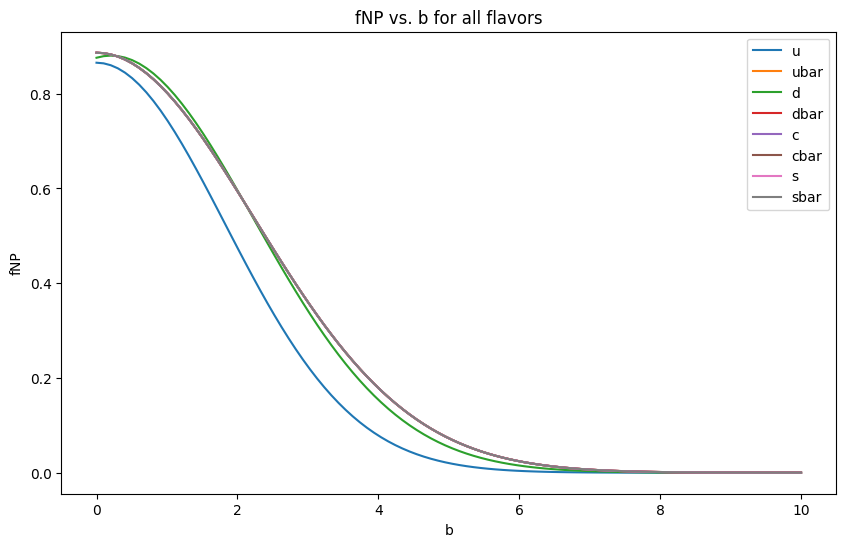

key: u, module: TMDPDF_u()
key: ubar, module: TMDPDFBase()
key: d, module: TMDPDF_d()
key: dbar, module: TMDPDFBase()
key: c, module: TMDPDFBase()
key: cbar, module: TMDPDFBase()
key: s, module: TMDPDFBase()
key: sbar, module: TMDPDFBase()
Updated results for all flavors:
u: 0.7214325070381165
ubar: 0.7057062983512878
d: 0.8055678606033325
dbar: 0.7434033751487732
c: 0.6539820432662964
cbar: 0.6397261619567871
s: 0.7847131490707397
sbar: 0.7847131490707397


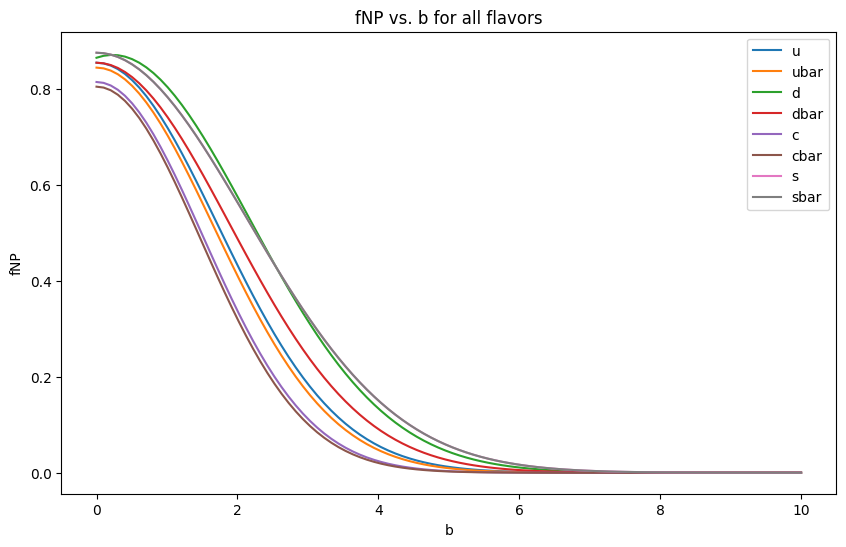

In [19]:
# Instantiate the model.
# The object model_fNP itself is not just a dictionary; 
# it is an nn.Module that contains an nn.ModuleDict as one of its attributes.
model_fNP = fNP(config)

# Define example inputs.
x = torch.tensor(0.3)
b = torch.tensor(1.0)

# Check
# Evaluate the model for all flavors (u, ubar, d, dbar, c, cbar, s, sbar).
results = model_fNP(x, b)
print("Results for all flavors:")
for flavor, val in results.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function.
utl.plot_fNP(model_fNP, x)
      
# Later in your fitting loop, you can update parameters:
# Assume you obtain an updated tensor (shape: 8 x max_params) from your fit.
new_params_tensor = torch.tensor([
    [0.27, 0.17, 0.13, 0.0],
    [0.28, 0.18, 0.14, 0.0],
    [0.23, 0.13, 0.12, 0.06],
    [0.24, 0.14, 0.13, 0.06],
    [0.32, 0.22, 0.17, 0.0],
    [0.33, 0.23, 0.18, 0.0],
    [0.21, 0.11, 0.11, 0.0],
    [0.21, 0.11, 0.11, 0.0]
], dtype=torch.float32)

model_fNP.set_parameters(new_params_tensor)

# Evaluate again.
results_updated = model_fNP(x, b)
print("Updated results for all flavors:")
for flavor, val in results_updated.items():
    print(f"{flavor}: {val.item()}")

# Call the plotting function again.
utl.plot_fNP(model_fNP, x)
   